<a href="https://colab.research.google.com/github/HungryCatsStudio/ml-models/blob/tensorflow-quantized/site/en/tutorials/quickstart/beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import tensorflow as tf
import numpy as np
import os

print("TensorFlow version:", tf.__version__)

HOME_DIR = os.getcwd()
MODEL_DIR = os.path.join(HOME_DIR, "models")

TensorFlow version: 2.15.0


In [42]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [43]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(28),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(10),
])

In [44]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [45]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [46]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 427us/step - loss: 0.3803 - accuracy: 0.8924
Epoch 2/5
1875/1875 [==============================] - 1s 441us/step - loss: 0.2166 - accuracy: 0.9377
Epoch 3/5
1875/1875 [==============================] - 1s 415us/step - loss: 0.1717 - accuracy: 0.9506
Epoch 4/5
1875/1875 [==============================] - 1s 412us/step - loss: 0.1456 - accuracy: 0.9578
Epoch 5/5
1875/1875 [==============================] - 1s 422us/step - loss: 0.1289 - accuracy: 0.9621


In [50]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(1000):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpek8_sfdd/assets


INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpek8_sfdd/assets
2024-02-08 11:48:36.733629: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-08 11:48:36.733641: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-08 11:48:36.733753: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpek8_sfdd
2024-02-08 11:48:36.734179: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-08 11:48:36.734183: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpek8_sfdd
2024-02-08 11:48:36.735378: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-08 11:48:36.755036: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpzhbcqr1t/assets


INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpzhbcqr1t/assets
/Users/antonio/Library/Python/3.9/lib/python/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-08 11:48:37.526646: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-08 11:48:37.526660: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-08 11:48:37.526811: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpzhbcqr1t
2024-02-08 11:48:37.527268: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-08 11:48:37.527274: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0

In [59]:
import pathlib

tflite_models_dir = pathlib.Path(MODEL_DIR)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"two_layer_perceptron.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24816

In [57]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices, argmax=True):

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    if argmax:
        predictions = np.zeros((len(test_image_indices),), dtype=int)
    else:
        predictions = np.zeros((len(test_image_indices), 10), dtype=float)

    for i, test_image_index in enumerate(test_image_indices):
        test_image = x_test[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax() if argmax else output

    return predictions

import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(x_test[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(y_test[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

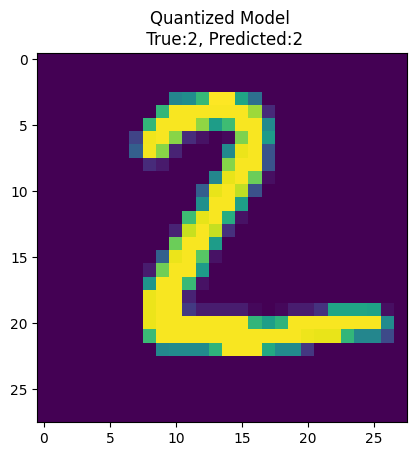

In [60]:
# test_model(tflite_model_file, test_image_index, model_type="Float")
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [61]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    test_image_indices = range(x_test.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(y_test== predictions) * 100) / len(x_test)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(x_test)))

In [62]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 96.1000% (Number of test samples=10000)


In [63]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.1359 - accuracy: 0.9613 - 168ms/epoch - 537us/step


[0.13593697547912598, 0.9613000154495239]

In [64]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [65]:
probability_model(x_test[0:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.24349037e-06, 2.49662079e-11, 5.91898061e-05, 7.75774475e-03,
        3.97712881e-07, 6.20048297e-07, 8.51243663e-13, 9.92062747e-01,
        1.48960544e-05, 1.02150814e-04]], dtype=float32)>

In [66]:
CHOSEN_EXAMPLE = 42

In [67]:
run_tflite_model(tflite_model_quant_file, [CHOSEN_EXAMPLE], argmax=False)

array([[110., 129., 131., 154., 208., 156., 114., 180., 160., 195.]])